# Data Modelling

In [1]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

In [2]:
#load the datasets
df=pd.read_csv('data/df_cleaned.csv')

In [3]:
df.head()

,subreddit,is_self,is_video,selftext,title,subreddit_id,created_utc,author,upvote_ratio,num_comments,...,title_lem,selftext_lem_stop,title_lem_stop,title_text_lem_stop,title_len,selftext_len,scores,compound,compound_score,is_yoga
0,Meditation,True,False,Now that I have burned all the past karma that...,Massive announcement concerning the future of ...,t5_2qnc9,1640907530,Extension_Mouse686,1.0,0,...,Massive announcement concerning the future of ...,Now I burned past karma weighing approximately...,Massive announcement concerning future human s...,Massive announcement concerning future human s...,18,345,"{'neg': 0.106, 'neu': 0.634, 'pos': 0.259, 'co...",0.9948,positive,0
1,Meditation,True,False,I have been meditating for 220 consecutive day...,Meditation Technique to deal with the first mi...,t5_2qnc9,1640903751,hartmanners,1.0,0,...,Meditation Technique to deal with the first mi...,I meditating 220 consecutive day today I usual...,Meditation Technique deal minute noisy mind,Meditation Technique deal minute noisy mind I ...,6,138,"{'neg': 0.101, 'neu': 0.646, 'pos': 0.253, 'co...",0.9766,positive,0
2,Meditation,True,False,I’ve tried to make meditation a part of my dai...,What should I focus on if I’m meditating witho...,t5_2qnc9,1640898514,v_philosoph,1.0,0,...,What should I focus on if I m meditating witho...,I tried make daily habit stick I notice I use ...,What I focus I meditating video guide,What I focus I meditating video guide I tried ...,7,48,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.6901,positive,0
3,Meditation,True,False,I have periods during the day where my mind is...,"Racing mind, adhd?",t5_2qnc9,1640896254,chris152772272727829,1.0,0,...,Racing mind adhd,I period day mind racing thought Is adhd Think...,Racing mind adhd,Racing mind adhd I period day mind racing thou...,3,18,"{'neg': 0.115, 'neu': 0.769, 'pos': 0.115, 'co...",0.0000,neutral,0
4,Meditation,True,False,I think I’ve been meditating correctly for a w...,Is there such a thing as “spiritual meditation...,t5_2qnc9,1640895782,OkStep3679,1.0,0,...,Is there such a thing a spiritual meditation v...,I think I meditating correctly consistent I su...,Is thing spiritual v,Is thing spiritual v I think I meditating corr...,4,39,"{'neg': 0.076, 'neu': 0.764, 'pos': 0.16, 'com...",0.3400,positive,0


## Table of Content

After cleaning our data in the previous notebook, we will start selecting and tuning a model to better predict where each post belongs to either r/yoga or r/meditation. Take in mind that this involves a binary classification problem. 

The steps we will take to indentify the best model:
1. Run Train-Test-Split
2. Transform data using a vectorizer
3. Fit model to training data
4. Generate predictions using test data
5. Evaluate model based on various evaluation metrics (accuracy, precision, recall, f1-score, ROC-AUC).
6. Select the best model and tune hyper-parameters

In this case we will utilize CountVectorizer(), TfidfVectorizer() and HashingVectorizer(). 
* Tfidf vectorizer function similar to CountVectorizer, except that it looks at the frequency of words in our data. This means that it downweights words that appear in many posts, while upweighting the rarer words.
* Hashing vectorizer is a vectorizer which uses the hashing trick to find the token string name to feature integer index mapping. Conversion of text documents into matrix is done by this vectorizer where it turns the collection of documents into a sparse matrix which are holding the token occurence counts. Advantages for hashing vectorizer include its low memory scalable and can be used in streaming or parallel pipeline.

We will test a range of classification techniques including Logistic Regression, Random Forest, Boosting, Multinomial Naive Bayes classification and Support Vector Machine (SVM) classification.

Accuracy and F-score will be our main metrics here, given that we're not too particularly concerned about minimizing either false negatives and false positives -- ideally we'd like to minimize both as far as possible.

### Baseline model

To compare our models with a baseline model, we will first create the baseline model using the normalized value of our response (y) or in other words the percentage of y within our target. This will be the representative of the simplest model whereby assigning a post randomly will yield ~60% chance of correct classification.

In [4]:
df['subreddit'].value_counts()

Meditation    994
yoga          659
Name: subreddit, dtype: int64

In [5]:
df['subreddit'].value_counts(normalize=True)

Meditation    0.601331
yoga          0.398669
Name: subreddit, dtype: float64

In [6]:
#In this dataset there are more posts from meditation. Our dataset is very unbalanced.

In [7]:
X = df['title_text_lem_stop']
y = df['is_yoga']

### Train Test Split

In [8]:
# Split our data into train and test data. We will stratify during the split to ensure that the train and test sets 
# contains the same percentage of samplesto avoid imbalanced classes.
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 random_state=42,
                                                 stratify=y) # account for slight class unbalanced 

### Model Preparation

In [9]:
# Vectorizer and Model imports:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
#custom stop word list identified
custom_stopword=['yoga','meditation','ha','lol','wa']

In [11]:
#wa is was but lemmatized but it brings no value to the study so i decided to remove it.

In [12]:
cv = CountVectorizer(stop_words=custom_stopword)
tvec = TfidfVectorizer(stop_words=custom_stopword)
hv= HashingVectorizer(stop_words=custom_stopword)

In [13]:
# Instantiate vectorizers
vectorizers = {'cvec': cv,
               'tvec': tvec,
               'hv': hv}

In [14]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=1_000, random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'nb': MultinomialNB(),
          'svc': SVC(random_state=42)}

In [15]:
# Function to run model -- input vectorizer and model
def model_run(vec, mod, vec_params={}, mod_params={}, grid_search=False):
    
    results = {}
    
    pipe = Pipeline([
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    if grid_search:
        gs = GridSearchCV(pipe, param_grid = {**vec_params, **mod_params}, verbose=3, n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    results['model'] = mod
    results['vectorizer'] = vec
    results['train'] = pipe.score(X_train, y_train)
    results['test'] = pipe.score(X_test, y_test)
    predictions = pipe.predict(X_test)
    results['roc'] = roc_auc_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        eval_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

### Model testing

In [16]:
# Create list to store model testing results
eval_list = []

### Benchmark Model

Since there are significant differences on the numerical features of the posts extracted from both subreddits (e.g. title/post length and number of comments), we should also test out a model with only these features. 

This model actually slightly better than the baseline with an R2 score of 64% on the test data.

In [17]:
df.head()

,subreddit,is_self,is_video,selftext,title,subreddit_id,created_utc,author,upvote_ratio,num_comments,...,title_lem,selftext_lem_stop,title_lem_stop,title_text_lem_stop,title_len,selftext_len,scores,compound,compound_score,is_yoga
0,Meditation,True,False,Now that I have burned all the past karma that...,Massive announcement concerning the future of ...,t5_2qnc9,1640907530,Extension_Mouse686,1.0,0,...,Massive announcement concerning the future of ...,Now I burned past karma weighing approximately...,Massive announcement concerning future human s...,Massive announcement concerning future human s...,18,345,"{'neg': 0.106, 'neu': 0.634, 'pos': 0.259, 'co...",0.9948,positive,0
1,Meditation,True,False,I have been meditating for 220 consecutive day...,Meditation Technique to deal with the first mi...,t5_2qnc9,1640903751,hartmanners,1.0,0,...,Meditation Technique to deal with the first mi...,I meditating 220 consecutive day today I usual...,Meditation Technique deal minute noisy mind,Meditation Technique deal minute noisy mind I ...,6,138,"{'neg': 0.101, 'neu': 0.646, 'pos': 0.253, 'co...",0.9766,positive,0
2,Meditation,True,False,I’ve tried to make meditation a part of my dai...,What should I focus on if I’m meditating witho...,t5_2qnc9,1640898514,v_philosoph,1.0,0,...,What should I focus on if I m meditating witho...,I tried make daily habit stick I notice I use ...,What I focus I meditating video guide,What I focus I meditating video guide I tried ...,7,48,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.6901,positive,0
3,Meditation,True,False,I have periods during the day where my mind is...,"Racing mind, adhd?",t5_2qnc9,1640896254,chris152772272727829,1.0,0,...,Racing mind adhd,I period day mind racing thought Is adhd Think...,Racing mind adhd,Racing mind adhd I period day mind racing thou...,3,18,"{'neg': 0.115, 'neu': 0.769, 'pos': 0.115, 'co...",0.0000,neutral,0
4,Meditation,True,False,I think I’ve been meditating correctly for a w...,Is there such a thing as “spiritual meditation...,t5_2qnc9,1640895782,OkStep3679,1.0,0,...,Is there such a thing a spiritual meditation v...,I think I meditating correctly consistent I su...,Is thing spiritual v,Is thing spiritual v I think I meditating corr...,4,39,"{'neg': 0.076, 'neu': 0.764, 'pos': 0.16, 'com...",0.3400,positive,0


In [18]:
df['title_len'] = len(df['title_lem_stop'])
df['selftext_len'] = len(df['selftext_lem_stop'])

In [19]:
# bm stands for benchmark
X_bm =df[['upvote_ratio', 'num_comments', 'title_len', 'selftext_len', 'compound']]
y_bm = df['is_yoga']

In [20]:
# Split our data into train and test data
X_bm_train, X_bm_test, y_bm_train, y_bm_test = train_test_split(X_bm, y_bm, test_size=0.3, stratify=y, random_state=42)

In [21]:
logreg = LogisticRegression()
logreg.fit(X_bm_train, y_bm_train)

LogisticRegression()

In [22]:
logreg.score(X_bm_train, y_bm_train)

0.6335350043215212

In [23]:
logreg.score(X_bm_test, y_bm_test)

0.6310483870967742

In [24]:
bm1_pred = logreg.predict(X_bm_test)

In [25]:
tn, fp, fn, tp = confusion_matrix(y_bm_test, bm1_pred).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 285
False Positives: 13
False Negatives: 170
True Positives: 28


True Positives are r/Yoga posts that were correctly classified by our model. True Negatives are r/Meditation posts that were correctly classified by our model. We can see that the model still incorrectly classifies about 13 posts from yoga subreddit and 165 from meditation subreddit which is not ideal. We will lose 165 potential yoga enthusiast!

In [26]:
print(classification_report(y_bm_test, bm1_pred))

              precision    recall  f1-score   support

           0       0.63      0.96      0.76       298
           1       0.68      0.14      0.23       198

    accuracy                           0.63       496
   macro avg       0.65      0.55      0.50       496
weighted avg       0.65      0.63      0.55       496



### Logistic Regression

In [27]:
# Logistic Regression with CountVectorizer
cvec_lr = model_run('cvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.9983857949959645,
 'test': 0.8768115942028986,
 'roc': 0.8536327126688572,
 'precision': 0.9384615384615385,
 'recall': 0.7393939393939394,
 'f_score': 0.8271186440677966}

True Negatives: 241
False Positives: 8
False Negatives: 43
True Positives: 122


In [28]:
# Logistic Regression with TfdifVectorizer
tvec_lr = model_run('tvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.9588377723970944,
 'test': 0.8743961352657005,
 'roc': 0.8444687842278205,
 'precision': 0.9829059829059829,
 'recall': 0.696969696969697,
 'f_score': 0.8156028368794327}

True Negatives: 247
False Positives: 2
False Negatives: 50
True Positives: 115


In [29]:
# Logistic Regression with TfdifVectorizer
tvec_lr = model_run('hv', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'hv',
 'train': 0.9515738498789347,
 'test': 0.8671497584541062,
 'roc': 0.8384446878422782,
 'precision': 0.9583333333333334,
 'recall': 0.696969696969697,
 'f_score': 0.8070175438596493}

True Negatives: 244
False Positives: 5
False Negatives: 50
True Positives: 115


HashingVectorizer() was also experimented as it has low memory requirement by storing tokens as strings but because this we can no longer retrieve the features after vectorizing.  Besides, we decided to drop using this in subsequent models due to weaker scores compared to the other two vectorizers.

Comparing TVEC,CVEC and HashVectorizer, clearly cvec yields a higher R2 score and f1-score.

### Random Forest / Extra Tree Classifier with CVEC

Random forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions. Each node in the decision tree works on a random subset of features to calculate the output which is aggregated to form the final output.

The Extra Trees classifier works similar to this, but incorporates bootstrap aggregation (or random sampling with replacement) in order to reduce variance and help with overfitting. In general, both methods provided worse results relative to logistic regression.

In [30]:
cvec_rf = model_run('cvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.8647342995169082,
 'roc': 0.8343921139101862,
 'precision': 0.9658119658119658,
 'recall': 0.6848484848484848,
 'f_score': 0.8014184397163121}

True Negatives: 245
False Positives: 4
False Negatives: 52
True Positives: 113


In [31]:
tvec_rf = model_run('tvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.8502415458937198,
 'roc': 0.8182548375319459,
 'precision': 0.9478260869565217,
 'recall': 0.6606060606060606,
 'f_score': 0.7785714285714286}

True Negatives: 243
False Positives: 6
False Negatives: 56
True Positives: 109


In [32]:
cvec_et = model_run('cvec', 'et')

### METRICS ###


{'model': 'et',
 'vectorizer': 'cvec',
 'train': 1.0,
 'test': 0.8671497584541062,
 'roc': 0.8435560423512231,
 'precision': 0.9230769230769231,
 'recall': 0.7272727272727273,
 'f_score': 0.8135593220338984}

True Negatives: 239
False Positives: 10
False Negatives: 45
True Positives: 120


In [33]:
tvec_et = model_run('tvec', 'et')

### METRICS ###


{'model': 'et',
 'vectorizer': 'tvec',
 'train': 1.0,
 'test': 0.857487922705314,
 'roc': 0.828368017524644,
 'precision': 0.9416666666666667,
 'recall': 0.6848484848484848,
 'f_score': 0.7929824561403509}

True Negatives: 242
False Positives: 7
False Negatives: 52
True Positives: 113


Both random forest and extra trees classifier did not score that well compared to logistic regression with cvec. We would need to explore further on how to get a better model.

### Adaptive Boost & Gradient Boost

Both of these methods are ensemble machine learning methods that combine multiple simple models into a single composite model. Both adaptive and gradient boosting involves building weak learners in a sequential fashion, with the final prediction generated by the weighted average of all the weak learners, where more weight is placed on stronger learners. Adaptive boosting is slightly different from gradient boosting, as it put more weight on misclassified samples and less weight on correctly classified samples.

In [34]:
cvec_ada = model_run('cvec', 'ada')

### METRICS ###


{'model': 'ada',
 'vectorizer': 'cvec',
 'train': 0.9112187247780468,
 'test': 0.8405797101449275,
 'roc': 0.8153340635268346,
 'precision': 0.8837209302325582,
 'recall': 0.6909090909090909,
 'f_score': 0.7755102040816326}

True Negatives: 234
False Positives: 15
False Negatives: 51
True Positives: 114


In [35]:
tvec_ada = model_run('tvec', 'ada')

### METRICS ###


{'model': 'ada',
 'vectorizer': 'tvec',
 'train': 0.9249394673123487,
 'test': 0.8236714975845411,
 'roc': 0.7961664841182914,
 'precision': 0.8650793650793651,
 'recall': 0.6606060606060606,
 'f_score': 0.7491408934707905}

True Negatives: 232
False Positives: 17
False Negatives: 56
True Positives: 109


In [36]:
cvec_gb = model_run('cvec', 'gb')

### METRICS ###


{'model': 'gb',
 'vectorizer': 'cvec',
 'train': 0.9281678773204197,
 'test': 0.8140096618357487,
 'roc': 0.7707557502738226,
 'precision': 0.9583333333333334,
 'recall': 0.5575757575757576,
 'f_score': 0.7049808429118775}

True Negatives: 245
False Positives: 4
False Negatives: 73
True Positives: 92


In [37]:
tvec_gb = model_run('tvec', 'gb')

### METRICS ###


{'model': 'gb',
 'vectorizer': 'tvec',
 'train': 0.930589184826473,
 'test': 0.8164251207729468,
 'roc': 0.7737860533041255,
 'precision': 0.9587628865979382,
 'recall': 0.5636363636363636,
 'f_score': 0.7099236641221374}

True Negatives: 245
False Positives: 4
False Negatives: 72
True Positives: 93


In this case, the adaptive boosting model is performing better than the gradient boosting model with a higher accuracy on test data and the f1-score.

### Naive Bayes

Naive Bayes classifiers works off Bayes' theroem, which describes the probability of an event, based on prior knowledge of conditions that might be related to the event.

In this case we will be using Multinomial Naive Bayes that looks at the frequency of the words present in our data.

In [38]:
cvec_nb = model_run('cvec', 'nb')

### METRICS ###


{'model': 'nb',
 'vectorizer': 'cvec',
 'train': 0.9685230024213075,
 'test': 0.9154589371980676,
 'roc': 0.9072289156626506,
 'precision': 0.9166666666666666,
 'recall': 0.8666666666666667,
 'f_score': 0.8909657320872274}

True Negatives: 236
False Positives: 13
False Negatives: 22
True Positives: 143


In [39]:
tvec_nb = model_run('tvec', 'nb')

### METRICS ###


{'model': 'nb',
 'vectorizer': 'tvec',
 'train': 0.9225181598062954,
 'test': 0.8357487922705314,
 'roc': 0.7949616648411829,
 'precision': 0.98989898989899,
 'recall': 0.593939393939394,
 'f_score': 0.7424242424242425}

True Negatives: 248
False Positives: 1
False Negatives: 67
True Positives: 98


The Multinomial Naive Bayes classifier with count vectorizer has an extremely high recall and f-score which is great at predicting r/yoga posts.

### Support Vector Machine Classifier

Support vector machine classifer separates data points using a hyperplane with the largest amount of margin and classifies them accordingly. In other words, the algorithm determines the best decision boundary between vectors that belong to a given group (or category) and vectors that do not belong to it.

In [40]:
cvec_svc = model_run('cvec', 'svc')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'cvec',
 'train': 0.9297820823244553,
 'test': 0.8260869565217391,
 'roc': 0.7859072654253377,
 'precision': 0.9603960396039604,
 'recall': 0.5878787878787879,
 'f_score': 0.7293233082706767}

True Negatives: 245
False Positives: 4
False Negatives: 68
True Positives: 97


In [41]:
tvec_svc = model_run('tvec', 'svc')

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'train': 0.9991928974979822,
 'test': 0.8671497584541062,
 'roc': 0.8384446878422782,
 'precision': 0.9583333333333334,
 'recall': 0.696969696969697,
 'f_score': 0.8070175438596493}

True Negatives: 244
False Positives: 5
False Negatives: 50
True Positives: 115


In [42]:
eval_df = pd.DataFrame(eval_list)

In [43]:
# Top results (Accuracy >= 0.790)
eval_df.sort_values(by='test', ascending=False).reset_index(drop=True).head(6)

,model,vectorizer,train,test,roc,precision,recall,f_score
0,nb,cvec,0.968523,0.915459,0.907229,0.916667,0.866667,0.890966
1,lr,cvec,0.998386,0.876812,0.853633,0.938462,0.739394,0.827119
2,lr,tvec,0.958838,0.874396,0.844469,0.982906,0.696970,0.815603
3,lr,hv,0.951574,0.867150,0.838445,0.958333,0.696970,0.807018
4,et,cvec,1.000000,0.867150,0.843556,0.923077,0.727273,0.813559
5,svc,tvec,0.999193,0.867150,0.838445,0.958333,0.696970,0.807018


we can see that both naive bayes and logistic regression with cvec rank better in terms of test score, roc score, recall and f1-score.

### Model Tuning

In [44]:
# Instantiate list to store tuning results
tuning_list = []

In [45]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': ['yoga', 'meditation', 'ha', 'lol', 'wa'],
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [46]:
cvec_params = {
    # Setting a limit of n-number of features included/vocab size
    'cvec__max_features': [None, 12_000],

    # Setting a minimum number of times the word/token has to appear in n-documents
    'cvec__min_df':[1, 2, 3],
    
    # Setting an upper threshold/max percentage of n% of documents from corpus 
    'cvec__max_df': [0.1, 0.2, 1],
    
    # Testing with bigrams and trigrams
    'cvec__ngram_range':[(1,1), (1,2)],
}

In [47]:
tvec_params = {
    'tvec__max_features': [None],
    'tvec__min_df':[3, 4, 5],
    'tvec__max_df': [0.2, 0.3, 0.4],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range':[(1,1), (1,2)]
}

### Model Parameters

In [48]:
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [49]:
lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1'],

     # Trying different alphas of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[0.1, 1, 10],
}

In [50]:
nb_params = {
    'nb__fit_prior': [True, False],
    'nb__alpha': [0.8, 0.9, 1.0],
}

In [51]:
svc_params = {
    'svc__C':[0.1, 1, 10],
    'svc__gamma':[0.01, 0.1, 0.3], 
    'svc__kernel':['linear','rbf'],
}

### Hyperparameter Tuning

#### Logistic Regression with CVEC

In [52]:
# Always stop_words & never trigrams (best_results without model tuning)
cvec_lr_gs = model_run('cvec', 'lr', vec_params=cvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
### BEST PARAMS ###


{'cvec__max_df': 0.2,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'train': 0.9717514124293786,
 'test': 0.8671497584541062,
 'roc': 0.840489229645856,
 'precision': 0.9435483870967742,
 'recall': 0.7090909090909091,
 'f_score': 0.8096885813148789}

True Negatives: 242
False Positives: 7
False Negatives: 48
True Positives: 117


#### Logistic Regression with TVEC

In [53]:
tvec_lr_gs = model_run('tvec', 'lr', vec_params=tvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
### BEST PARAMS ###


{'lr__C': 10,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.2,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'train': 0.9975786924939467,
 'test': 0.8840579710144928,
 'roc': 0.8627236217597664,
 'precision': 0.9398496240601504,
 'recall': 0.7575757575757576,
 'f_score': 0.8389261744966443}

True Negatives: 241
False Positives: 8
False Negatives: 40
True Positives: 125


#### Multinomial Naive Bayes with CVEC

In [54]:
cvec_nb_gs = model_run('cvec', 'nb', vec_params=cvec_params, mod_params=nb_params, grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
### BEST PARAMS ###


{'cvec__max_df': 0.2,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.8,
 'nb__fit_prior': True}

### METRICS ###


{'model': 'nb',
 'vectorizer': 'cvec',
 'train': 0.9975786924939467,
 'test': 0.8913043478260869,
 'roc': 0.8718145308506755,
 'precision': 0.9411764705882353,
 'recall': 0.7757575757575758,
 'f_score': 0.8504983388704319}

True Negatives: 241
False Positives: 8
False Negatives: 37
True Positives: 128


### Support Machine Classifier with TVEC

In [55]:
tvec_svc_gs = model_run('tvec', 'svc', vec_params=tvec_params, mod_params=svc_params, grid_search=True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
### BEST PARAMS ###


{'svc__C': 1,
 'svc__gamma': 0.01,
 'svc__kernel': 'linear',
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'svc',
 'vectorizer': 'tvec',
 'train': 0.9846650524616626,
 'test': 0.8792270531400966,
 'roc': 0.8546184738955823,
 'precision': 0.952755905511811,
 'recall': 0.7333333333333333,
 'f_score': 0.8287671232876712}

True Negatives: 243
False Positives: 6
False Negatives: 44
True Positives: 121


### Final Model Selection

In [56]:
tuning_df = pd.DataFrame(tuning_list)

In [57]:
tuning_df.sort_values(by=['test', 'roc'], ascending=False).reset_index(drop=True)

,model,vectorizer,train,test,roc,precision,recall,f_score
0,nb,cvec,0.997579,0.891304,0.871815,0.941176,0.775758,0.850498
1,lr,tvec,0.997579,0.884058,0.862724,0.939850,0.757576,0.838926
2,svc,tvec,0.984665,0.879227,0.854618,0.952756,0.733333,0.828767
3,lr,cvec,0.971751,0.867150,0.840489,0.943548,0.709091,0.809689


From the table above, multinomial naive bayes with count vectorizer returned the highest R2 accuracy of 0.89 in gridsearch while 0.92 w/o gridsearch even on the default params. This is because grid search creates subsamples of the data repeatedly. That means the model is trained on 80% of x_train in each iteration and the results are the mean of predictions on the other 20%. GridSearch is used for selecting a combination of hyperparameters, performance estimation has not yet happened. The only comparison we could be making is between the parameter combinations within the CV itself.

In other words, our model is able accurately predict about 89% of the test data based on our text features. The model also has the best AUC-ROC score of 0.85. We can interpret this metric as proof that that this model is the best at distinguishing between classes. The model does particularly very well in terms of recall (0.77), with only 37 false negatives (predicted r/meditaion but actually belong to r/Yoga posts which is potentially a loss of yoga enthusiast).

In summary, our final model:

* The model uses Cvec Vectorization with no max feature limit
* includes only words or n-grams that appear in at least 1 post
* ignores terms that that appear in more than 20% of posts
* uses naive Bayes with Ridge regularization( alpha= 0.8)

Our model is still overfitting quite a bit as indicated by the large gap between training and test scores, but this seems to be the limit to which we can push our model.

### AUC-ROC Curve

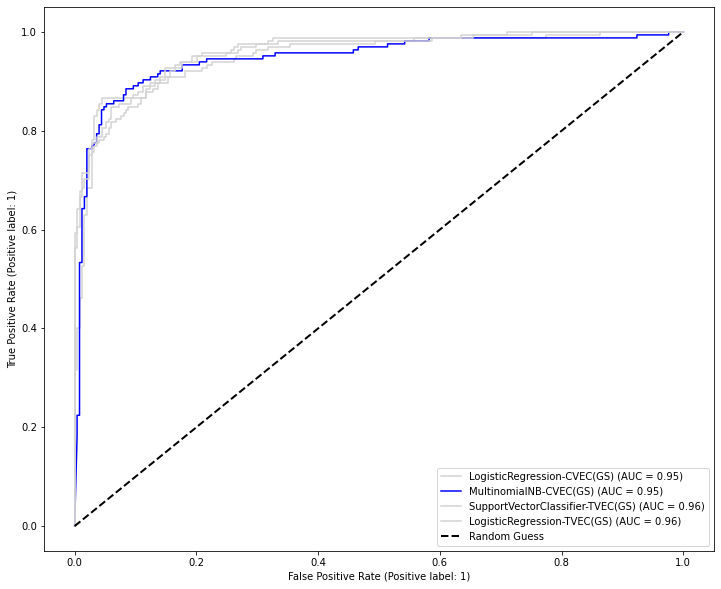

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(cvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-CVEC(GS)', color='lightgrey')
plot_roc_curve(cvec_nb_gs, X_test, y_test, ax=ax, name='MultinomialNB-CVEC(GS)', color='blue')
plot_roc_curve(tvec_svc_gs, X_test, y_test, ax=ax, name='SupportVectorClassifier-TVEC(GS)', color='lightgrey')
plot_roc_curve(tvec_lr_gs, X_test, y_test, ax=ax, name='LogisticRegression-TVEC(GS)', color='lightgrey')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
plt.legend();

We can see that our chosen model, Naive Bayes with CVEC does pretty well with an ROC score of 0.95 which is closer to 1 as indicated by the AUC-ROC curve. The other classifiers all come pretty close in the range 0.95-0.96 but we will choose Naive bayes since its overall balance of accuracy,recall,roc,f1-score is the best.

### Model Insights

Each post has a probability that a model assigns it to either r/Yoga or r/Meditation post. What we can infer from these models is the best probability that it would be classified and what are the top predictors that can help make better marketing decisions.

In [59]:
#accessng the dictionary in gridsearch
cvec_nb_gs.best_estimator_.named_steps

{'cvec': CountVectorizer(max_df=0.2, ngram_range=(1, 2),
                 stop_words=['yoga', 'meditation', 'ha', 'lol', 'wa']),
 'nb': MultinomialNB(alpha=0.8)}

In [60]:
#convert the probabilities of each n-gram from yoga subreddit to a dataframe
yoga_proba_df=pd.DataFrame(np.exp(cvec_nb_gs.best_estimator_.named_steps.nb.feature_log_prob_[1]),columns=['proba'])

In [61]:
cvec_nb_gs.best_estimator_.steps[0][1].get_feature_names()[:5]

['00', '00 12', '00 43', '00 cet', '00 pm']

In [62]:
#Matching the proba to its n-gram
yoga_proba_df['feature']=cvec_nb_gs.best_estimator_.steps[0][1].get_feature_names()

In [63]:
#sorting to only keep top 15 n-gram for r/yoga
yoga_proba_df_15=yoga_proba_df.sort_values(by=['proba'],ascending=False)[:15]

In [64]:
#convert the probabilities of each n-gram from meditation subreddit to a dataframe
med_proba_df=pd.DataFrame(np.exp(cvec_nb_gs.best_estimator_.named_steps.nb.feature_log_prob_[0]),columns=['proba'])

In [65]:
#Matching the proba to its n-gram
med_proba_df['feature']=cvec_nb_gs.best_estimator_.steps[0][1].get_feature_names()

In [66]:
#sorting to only keep top 15 n-gram for r/yoga
med_proba_df_15=med_proba_df.sort_values(by=['proba'],ascending=False)[:15]

In [67]:
med_proba_df_15

,proba,feature
54551,0.002969,thought
33688,0.002356,mind
33040,0.002196,meditating
53339,0.002012,the
29815,0.001752,life
16779,0.001690,experience
53855,0.001614,thing
58875,0.001468,want
32879,0.001430,meditate
54100,0.001376,think


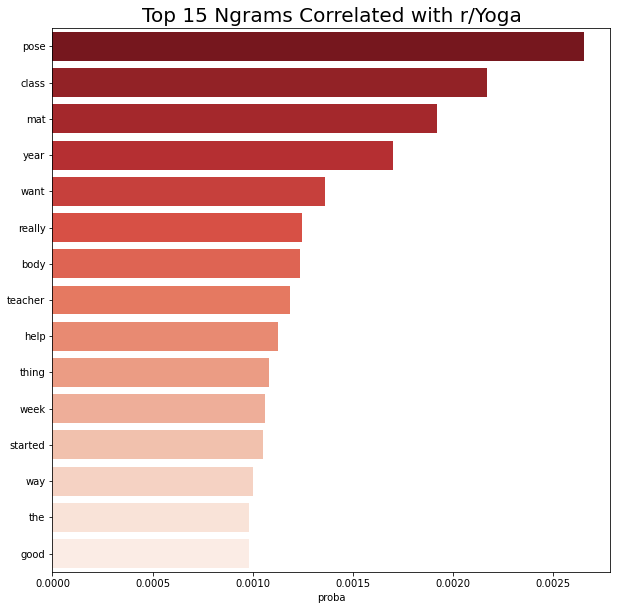

In [68]:
plt.figure(figsize=(10,10))
sns.barplot(data=yoga_proba_df_15, x=yoga_proba_df_15['proba'], y=yoga_proba_df_15['feature'], palette='Reds_r')
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with r/Yoga', fontsize=20);

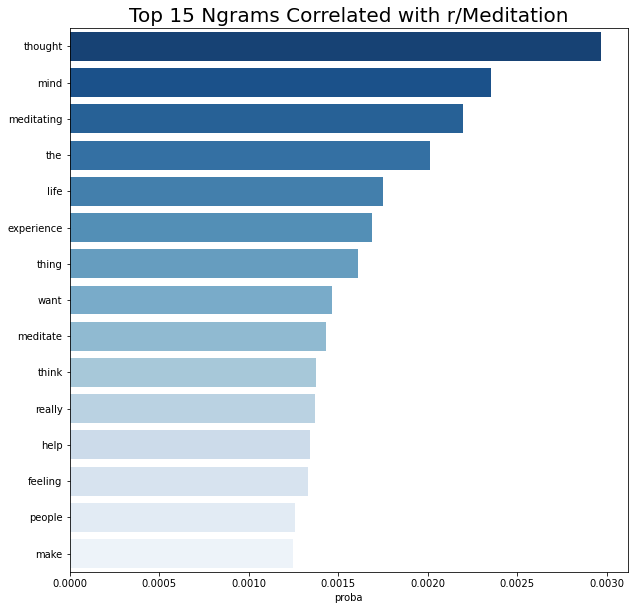

In [69]:
plt.figure(figsize=(10,10))
sns.barplot(data=med_proba_df_15, x=med_proba_df_15['proba'], y=med_proba_df_15['feature'], palette='Blues_r')
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with r/Meditation', fontsize=20);

From the yoga top words barplot, we can infer that r/yoga posts generally focus on some key words such as pose, class, mat,body and help.
This could mean that yoga enthusiast are keen to learn different poses. We could also see that having class or mat package promotions can really help bring in users to join yoga.
We could also market in a way that yoga helps improve body posture and wellness.

From the meditation top words barplot, there are a few striking words such as thought, mind, experience and feeling.
This could be incorporated to the marketing in a sense that yoga can also helps improve calmness and mind refreshing experience.

#### Finding overlapping interest among yoga and meditation

In [70]:
yoga_topwords_30=yoga_proba_df.sort_values(by=['proba'],ascending=False)[:30]['feature'].values.tolist()

In [71]:
med_topwords_30=med_proba_df.sort_values(by=['proba'],ascending=False)[:30]['feature'].values.tolist()

In [72]:
yoga_topwords_30

['pose',
 'class',
 'mat',
 'year',
 'want',
 'really',
 'body',
 'teacher',
 'help',
 'thing',
 'week',
 'started',
 'way',
 'the',
 'good',
 'leg',
 'studio',
 'my',
 'pain',
 'thanks',
 'video',
 'lot',
 'dog',
 'what',
 'make',
 'need',
 'love',
 'new',
 'month',
 'work']

In [73]:
med_topwords_30

['thought',
 'mind',
 'meditating',
 'the',
 'life',
 'experience',
 'thing',
 'want',
 'meditate',
 'think',
 'really',
 'help',
 'feeling',
 'people',
 'make',
 'year',
 'breath',
 'way',
 'body',
 'focus',
 'started',
 'what',
 'but',
 'you',
 'anxiety',
 'this',
 'breathing',
 'start',
 'need',
 'felt']

In [74]:
pip install matplotlib_venn

Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

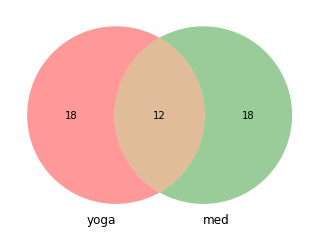

In [76]:
v=venn2([set(yoga_topwords_30), 
       set(med_topwords_30)],
       set_labels=('yoga', 'med')
     );

Interesting find is that we have 12 common interest among the 2 subreddits.

From the venn diagram we can get a better insight on how to market to different individuals
1. existing yoga enthusiast
2. yoga and meditation enthusiast which share the same interests
3. meditation enthusiast

In [77]:
#1. only yoga set has these words to address existing yoga enthusiast
set(yoga_topwords_30).difference(set(med_topwords_30))

{'class',
 'dog',
 'good',
 'leg',
 'lot',
 'love',
 'mat',
 'month',
 'my',
 'new',
 'pain',
 'pose',
 'studio',
 'teacher',
 'thanks',
 'video',
 'week',
 'work'}

For the 1st group its no surpise that the top 30 words have covered on how to market it. So we will look into the 2nd group by the words in the r/yoga and r/meditation intersection.

In [78]:
#2. intersection or common words between yoga and meditation for both yoga and meditation groups.
set(yoga_topwords_30).intersection(set(med_topwords_30))

{'body',
 'help',
 'make',
 'need',
 'really',
 'started',
 'the',
 'thing',
 'want',
 'way',
 'what',
 'year'}

As we can see, to improve on the attraction for both yoga and meditation enthusiast are mainly related to body and wellness

In [79]:
#3. only med set has these words
set(med_topwords_30).difference(set(yoga_topwords_30))

{'anxiety',
 'breath',
 'breathing',
 'but',
 'experience',
 'feeling',
 'felt',
 'focus',
 'life',
 'meditate',
 'meditating',
 'mind',
 'people',
 'start',
 'think',
 'this',
 'thought',
 'you'}

I think that meditation subreddit top words focuses mainly on anxiety, breathing,feeling,focus and life. This means that meditation has something that yoga lacks of which is it helps anxiety and breathing but this can be incorporated in the marketing because yoga does help regulate breathing during the exercise and it can be good for reducing anxiety.

### Model Limitations

As a caveat, our model does have some limitations when it comes to predicting r/yoga posts. Mentioning very normal words like life can throw off our model. To further improve model accuracy, we'd ideally need to train our model to recognize slang words for yoga and meditation which might not be picked up by the model.

### Conclusion & Recommendations

In conclusion, the model we chosed to better classify the posts for r/yoga and r/meditation is the naive bayes model with count vectorizer due to its higher r2 score, recall and f-1 score as a whole.

Besides maximizing the funds and manpower to classify posts from two different subreddits based on their title and selftext, there are a number of other possible applications for this model.

By looking at the probabilities associated with each post, marketing teams can better appeal to the potential clients when they are promoting to the yoga or meditation users. In fact, this can also be useful as words can be trending with time but withi this model we can accurately ride the trend with words that have high probability of being classified as yoga.

The sentiment analysis we implemented can also determine the mood of the potential clients which either is a positive attraction to yoga or vice versa.

The recommendation we would propose at this point of time for the marketing team is that we can focus on are as follows:
1. Provide free mat or foam rollers to entice the clients to join yoga especially for those that are already interested in yoga.
2. Promote body fitness and wellness for those who are both yoga and meditation enthusiast.
3. Transition the business in a way that also appeal to meditation enthusiast whereby yoga also focuses on breathing regulation and helps to reduce anxiety. The community and people from yoga can also help newcomers settle in easier.

### Reference

1. https://towardsdatascience.com/gradient-boosting-classification-explained-through-python-60cc980eeb3d
2. https://medium.com/analytics-vidhya/visualizing-phrase-prominence-and-category-association-with-scattertext-and-pytextrank-f7a5f036d4d2
3. https://github.com/LoLei/redditcleaner